Wed Jul 2nd 2025,
Jakob Balkovec

This serves as a follow up to the report from `02_patch_extraction.ipynb`. Here I took a deeper dive into what algorithm works best (if the performance differs at all...) for reducing the size of the label tuple down to just 1.

In [69]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mtpltlib_patches

import numpy as np
import pandas as pd

from pathlib import Path

import math

import json
import sys

from typing import Tuple

from shapely.geometry import Point, Polygon, box
from shapely.affinity import scale, rotate

from functools import partial

from sklearn.cluster import DBSCAN

# this is to filter "shapely's" warning abt some intersection stuff...
#   I tried debugging it but gave up...if this casues more issues down the road,
#   I'll put more effort into fixing it
import warnings
warnings.filterwarnings("ignore", message=".*invalid value encountered in intersection.*")

# ======
sys.path.append(str(Path("../XMLparser").resolve()))

from lesion_parser import LesionXMLParser
from utils import parse_txt_file
# ======


## Configuration

In [58]:
COLOR_MAP = {
    'haemorrhages': ('blue', 0.3),
    'red_small_dots': ('red', 0.3),
    'hard_exudates': ('green', 0.3),
    'soft_exudates': ('orange', 0.3),
    'disc': ('purple', 0.3),
    'irma': ('cyan', 0.3),
    'neovascularisation': ('magenta', 0.3),
    'fundus_area': ('yellow', 0.3)
}

TICK_COLOR_MAP = {
    'haemorrhages': 'white',
    'red_small_dots': 'yellow',
    'hard_exudates': 'black',
    'soft_exudates': 'blue',
    'disc': 'white',
    'irma': 'black',
    'neovascularisation': 'yellow',
    'fundus_area': 'black'
}

PATCH_HALF = 12 # since patches are 25x25
PATCH_SIZE = 25

IMAGE_SIZE = r"1152 x 1500"

PATCH_ROOT = Path("../data/patches")
DATA_ROOT = Path("../data/raw")

# known from earlier
TARGET_PATCHES = [745, 1417, 1647, 1723, 1772, 1773, 1774, 1840]


## Weigths

In [46]:
# linear severity scaling
WEIGHTS_MAP_1 = {
    'fundus_area':         -1.00,
    'disc':                -1.00,
    'red_small_dots':      0.10,
    'hard_exudates':       0.30,
    'haemorrhages':        0.50,
    'soft_exudates':       0.65,
    'irma':                0.80,
    'neovascularisation':  1.00,
}

# risk adjusted weighting
# paper: https://www.mdpi.com/2227-9059/13/6/1446
WEIGHTS_MAP_2 = {
    'fundus_area':         -1.00,
    'disc':                -1.00,
    'red_small_dots':      0.05,
    'hard_exudates':       0.20,
    'haemorrhages':        0.40,
    'soft_exudates':       0.70,
    'irma':                0.85,
    'neovascularisation':  1.00,
}

# visual salience + clinical tradeoff -> how obvious something looks
WEIGHTS_MAP_3 = {
    'fundus_area':         -1.00,
    'disc':                -1.00,
    'red_small_dots':      0.50,
    'hard_exudates':       0.60,
    'haemorrhages':        0.70,
    'soft_exudates':       0.65,
    'irma':                0.80,
    'neovascularisation':  0.95
}


> The **[Paper](https://www.mdpi.com/2227-9059/13/6/1446)** can be found by clicking on `[Paper]`.

The `-1.00` values for `fundus_area` and `disc` are intentional...these aren't actual lesions, so giving them zero would risk a tie-break scenario (where a real lesion with zero area could be overridden, or comparing two areas that = 0). By setting them to `-1.00`, we guarantee they never get selected when resolving duplicate labels (filter out negatives).

As for the maps: 
- `WEIGHTS_MAP_1` is a straightforward linear scale from early to late-stage DR features. It's a good default...simple, logical, and mirrors the general clinical progression...<br>

- `WEIGHTS_MAP_2` is based on published clinical severity data, assigning lower scores to early signs like red dots and higher ones to lesions tied to proliferative DR, like IRMA and neovascularisation. This one adds more medical weight to the resolution logic.<br>

- `WEIGHTS_MAP_3` blends clinical significance with how visually dominant a lesion tends to be. For example, red small dots get a moderate weight because they’re early indicators but also tend to be very visible, while neovascularisation ranks high because it's both serious and visually clear...This makes it a good "middle-ground" when area alone isn’t enough.<br>



## Functions

### Plotting Functions

In [23]:
def plot_patch_with_lesions(patch_row, lesions_df, color='red'):
    # pre: patch_row is a row from the patch DataFrame; lesions_df is the full XML DataFrame
    # post: plots the patch with a rectangle and any included lesion markers
    # desc: overlays the patch region and marks lesions within it

    coords = patch_row['coordinates']
    patch_img = patch_row['patch']
    patch_center = patch_row['center']
    patch_label = patch_row['label']
    patch_no = patch_row['patch_no']

    x1, y1 = coords['top_left']
    x2, y2 = coords['bottom_right']

    fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
    ax.imshow(patch_img if len(patch_img.shape) == 3 else patch_img, cmap='gray' if len(patch_img.shape) == 2 else None)

    ax.set_title(f"Patch #{patch_no} | Label: {patch_label}", fontsize=8)

    text_str = (
        f"Coords: TL=({x1},{y1}) BR=({x2},{y2})\n"
        f"Center: {patch_center}"
    )

    fig.text(0.5, -0.05, text_str, ha='center', va='top', fontsize=7)


    ax.axis('off')

    cx = patch_center[0] - x1
    cy = patch_center[1] - y1

    matching_lesions = lesions_df[
        lesions_df.apply(lambda row: x1 <= row['x'] <= x2 and y1 <= row['y'] <= y2, axis=1)
    ]

    for _, lesion in matching_lesions.iterrows():
        lx = int(lesion['x'] - x1)
        ly = int(lesion['y'] - y1)
        ax.plot(lx, ly, marker='x', color='yellow', markersize=2)
        ax.text(lx + 1, ly + 1, lesion['type'], fontsize=5, color='yellow')

    plt.tight_layout()
    plt.show()

def visualize_lesion_regions(df, lesions_df=None, n_cols=4, from_relabel=False):
    # pre: df is the patch DataFrame; if from_relabel is True, lesions_df is ignored
    # post: displays a grid of patches with overlaid lesion shapes
    # desc: unified visualizer that works on original or relabeled patches using a flag

    # note: [RELABELED] visualize_lesion_regions(relabeled_df, from_relabel=True)
    # note: [ORIGINAL] visualize_lesion_regions(original_patches_df, lesions_df=lesions_pd_frame, from_relabel=False)

    if from_relabel:
        all_lesions = []
        for _, row in df.iterrows():
            if isinstance(row.get("relabel"), list):
                for lesion in row["relabel"]:
                    lesion['patch_no'] = row['patch_no']
                    all_lesions.append(lesion)
        lesions_df = pd.DataFrame(all_lesions)

    n = len(df)
    n_rows = (n + n_cols - 1) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3.5, n_rows * 3.5), dpi=150)
    axs = axs.flatten()

    for i, (_, patch) in enumerate(df.iterrows()):
        coords = patch['coordinates']
        patch_img = patch['patch']
        x1, y1 = coords['top_left']
        x2, y2 = coords['bottom_right']
        ax = axs[i]

        ax.imshow(patch_img if len(patch_img.shape) == 3 else patch_img, cmap='gray' if len(patch_img.shape) == 2 else None)

        label_text = patch.get('relabel_label', patch.get('label', ''))
        if isinstance(label_text, (list, tuple)):
            label_text = ", ".join(map(str, label_text))
        if pd.isna(label_text):
            label_text = ""

        ax.set_title(f"#{patch['patch_no']} | {label_text}", fontsize=8)

        local_lesions = lesions_df[
            lesions_df.apply(lambda row: x1 <= row['x'] <= x2 and y1 <= row['y'] <= y2, axis=1)
        ]

        for _, lesion in local_lesions.iterrows():
            lx, ly = lesion['x'] - x1, lesion['y'] - y1
            radius = lesion.get('radius', 5)
            ltype = str(lesion.get('type', '')).strip().lower()
            rtype = lesion.get("region_type", "")
            polygon_points = lesion.get("polygon_points", [])

            tick_color = TICK_COLOR_MAP.get(ltype, 'white')
            circle_color = COLOR_MAP.get(ltype, ('gray', 0.3))[0]

            ax.plot(lx, ly, marker='x', color=tick_color, markersize=3.5, linewidth=0.6)

            if rtype == "circleregion":
                circ = mtpltlib_patches.Circle((lx, ly), radius=radius, linewidth=0.5,
                                               edgecolor=circle_color, facecolor=circle_color, alpha=0.3)
                ax.add_patch(circ)

            elif rtype == "polygonregion":
                local_poly_points = [(px - x1, py - y1) for (px, py) in polygon_points]
                poly = mtpltlib_patches.Polygon(local_poly_points, closed=True, linewidth=0.5,
                                                edgecolor=circle_color, facecolor=circle_color, alpha=0.3)
                ax.add_patch(poly)

            elif rtype == "ellipseregion":
                ellipse = mtpltlib_patches.Ellipse((lx, ly), width=2*lesion.get("radius_x", 5),
                                                   height=2*lesion.get("radius_y", 5),
                                                   angle=lesion.get("angle", 0), linewidth=0.5,
                                                   edgecolor=circle_color, facecolor=circle_color, alpha=0.3)
                ax.add_patch(ellipse)

        ax.axis('off')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


### Utility Functions

In [24]:
def generate_clahe_image_green_channel(grayscale_img, clip_limit=2.0, tile_grid_size=(8, 8)):
    # pre: grayscale_img is a NumPy array in grayscale format
    # post: green chanel of the image is enhanced using CLAHE
    # desc: applies CLAHE to the grayscale image with specified clip limit and tile grid size

    # note: works the same as the one on top of this one. The top one expects 3 channels (RGB),
    #       thus when passing in the green channel image, it throws an error.
    #       this one expects a single channel grayscale image.
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(grayscale_img)

def is_lesion_in_patch(patch_coords, lesion_x, lesion_y):
    # pre: patch_coords is a dictionary with 'top_left' and 'bottom_right' keys, lesion_x and lesion_y are coordinates
    # post: returns True if lesion is within the patch coordinates, False otherwise
    # desc: checks if lesion coordinates are within the specified patch coordinates

    x1, y1 = patch_coords['top_left']
    x2, y2 = patch_coords['bottom_right']
    return x1 <= lesion_x <= x2 and y1 <= lesion_y <= y2

def compute_polygon_area(points):
    # pre: points is a list of tuples (x, y) representing polygon vertices
    # post: returns the area of the polygon defined by the points
    # desc: calculates the area of a polygon using the shoelace formula
    if not points or len(points) < 3:
        return 0
    x_coords, y_coords = zip(*points)
    return 0.5 * abs(
        sum(x * y_next for x, y_next in zip(x_coords, y_coords[1:] + y_coords[:1])) -
        sum(y * x_next for y, x_next in zip(y_coords, x_coords[1:] + x_coords[:1]))
    )

def get_lesion_geometry(lesion):
    # pre: lesion has to be a valid entry in the dataframe
    # post: a "shapely" shape wrt to "region_type" in the df
    # desc: converts it to a "shapely" shape

    x, y = lesion['x'], lesion['y']
    rtype = lesion['region_type']

    if rtype == 'circleregion':
        return Point(x, y).buffer(lesion['radius'])

    elif rtype == 'ellipseregion':
        base = Point(x, y).buffer(1)
        scaled = scale(base, lesion['radius_x'], lesion['radius_y'])
        return rotate(scaled, lesion['angle'], origin=(x, y), use_radians=False)

    elif rtype == 'polygonregion':
        return Polygon(lesion['polygon_points'])

    return None


### Data Processing Functions (Base)

This is the part that does the lazy deduplication of the labels and pre-processes the data for further processing.

In [25]:
def deduplicate_labels(label):
    # pre: label can be a single label or a list/tuple of labels
    # post: returns a single label or a tuple of unique labels
    # desc: ensures that labels are unique and sorted, especially for multiple lesion types

    # note: this is lazy and only here to decrease the workload later on.

    def clean(x):
        return str(x).strip().capitalize()

    if isinstance(label, (list, tuple)):
        cleaned = [clean(l) for l in label]
        return tuple(sorted(set(cleaned))) if len(set(cleaned)) > 1 else clean(cleaned[0])
    elif isinstance(label, str):
        return clean(label)
    return None

def extract_largest_lesions_from_relabel(df, by_shape=False):
    # pre: df is a DataFrame with a 'relabel' column containing list-of-dict lesion annotations
    # post: returns a flat DataFrame with deduplicated lesion entries (largest per type/region), preserving full fields
    # desc: Keeps only the largest lesion for each (type, region_type) per patch

    # note:
    # We retain only the largest lesion *per type* in each patch, ignoring shape differences.
    # This is valid for patch-based labeling because lesion boundaries may be clipped,
    # and the goal is to assign one dominant label per patch.

    # note:
    # added a new flag "by_shape" which is only meant to be used when using the area based approach.
    # if used during other approaches, it may cause inconsistencies, and undefined behavior...

    # by_shape = extract the shape with the largest area from the list of at least 2

    def largest_lesions(relabel_list):
        if not isinstance(relabel_list, list):
            return []

        lesion_map = {}
        for lesion in relabel_list:
            ltype = str(lesion.get("type", "")).strip().lower()
            rtype = lesion.get("region_type", "").strip().lower()
            key = (ltype, rtype) if by_shape else (ltype, )

            if rtype == "circleregion":
                area = lesion.get("radius", 0) ** 2 * math.pi
            elif rtype == "ellipseregion":
                area = lesion.get("radius_x", 0) * lesion.get("radius_y", 0) * math.pi
            elif rtype == "polygonregion":
                area = compute_polygon_area(lesion.get("polygon_points", []))
            else:
                area = 0

            if key not in lesion_map or lesion_map[key][0] < area:
                lesion_map[key] = (area, lesion)

        return [l[1] for l in lesion_map.values()]

    df = df.copy()
    df["relabel"] = df["relabel"].apply(largest_lesions)
    return df


### Patch Extraction Function

In [26]:
def extract_patches_with_metadata(image, patch_size, source_img_name, skip_non_full_patches=False):
    # pre: image is a NumPy array; patch_size is int > 0; source_img_name is str
    # post: returns a list of dicts, each describing a patch and its metadata
    # desc: slices image into non-overlapping patches and attaches spatial/traceability info

    # note: if skip_non_full_patches is True, it skips patches that do not fit the full patch size
    #  -> mostly patches along the edges that are something like 25 x 20
    #       -> I say mostly because I haven't tested this thoroughly
    #          with all possible patch sizes, just noticed 4 cases

    height, width = image.shape[:2]
    patches = []

    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            x1, y1 = x, y
            x2, y2 = x + patch_size, y + patch_size

            if skip_non_full_patches and (x2 > width or y2 > height):
                continue  # skip incomplete patch

            x2 = min(x2, width)
            y2 = min(y2, height)

            patch = image[y1:y2, x1:x2]
            center = ((x1 + x2) // 2, (y1 + y2) // 2)

            patch_info = {
                "source_img": source_img_name,
                "patch_no": len(patches) + 1,
                "patch": patch,
                "center": center,
                "coordinates": {
                    "top_left": (x1, y1),
                    "top_right": (x2 - 1, y1),
                    "bottom_left": (x1, y2 - 1),
                    "bottom_right": (x2 - 1, y2 - 1)
                },
                "label": None,
                "overlap_flag": False
            }

            patches.append(patch_info)

    return patches


### Labeling Functions

In [27]:
# does the original labeling...
def label_patches_from_lesions(patches_df, lesions_df):
    # pre: patches_df is a DataFrame with 'coordinates' column containing patch coordinates,
    #      lesions_df is a DataFrame with 'x', 'y', and 'type' columns for lesion coordinates and types
    # post: returns a DataFrame with updated labels for each patch based on lesion overlaps
    # desc: labels each patch based on whether it contains lesions, and flags overlaps

    updated_patches = []

    for idx, patch in patches_df.iterrows():
        matches = lesions_df[
            lesions_df.apply(
                lambda row: is_lesion_in_patch(patch['coordinates'], row['x'], row['y']),
                axis=1
            )
        ]

        if matches.empty:
            label = "healthy"
            overlap = False
        else:
            raw_labels = matches['type'].tolist()
            label = deduplicate_labels(raw_labels)
            overlap = len(set(raw_labels)) > 1

        patch['lesion_id'] = idx
        patch['label'] = label
        patch['overlap_flag'] = overlap
        updated_patches.append(patch)

    return pd.DataFrame(updated_patches)

# PUBLIC API
def relabel_patches_with(patches_df, lesions_df, strategy_fn):
    # pre: 'patches_df' contains patch metadata; 'lesions_df' has lesion annotations
    #      strategy_fn is a function that takes (patch_coords, local_lesions) and returns (label, metadata, lesion_subset)
    # post: adds relabel info to patch_df using results of strategy_fn
    # desc: delegates patch relabeling to a user-defined function per patch

    output_df = patches_df.copy()
    relabel_labels, metadata_list, lesion_groups = [], [], []

    for _, patch in output_df.iterrows():
        coords = patch['coordinates']
        x1, y1 = coords['top_left']
        x2, y2 = coords['bottom_right']

        local_lesions = lesions_df[
            lesions_df.apply(lambda row: x1 <= row['x'] <= x2 and y1 <= row['y'] <= y2, axis=1)
        ]

        label, metadata, group = strategy_fn(coords, local_lesions)
        relabel_labels.append(label)
        metadata_list.append(metadata)
        lesion_groups.append(group)

    output_df['relabel_label'] = relabel_labels
    output_df['relabel_meta'] = metadata_list
    output_df['relabel'] = lesion_groups

    return output_df


---

## Parsing the Data

In [28]:
parsed_text_input = parse_txt_file("../data/raw/ddb1_v02_01_test_plain.txt")
single_entry = parsed_text_input[0]

parser = LesionXMLParser(xml_input=[single_entry], root_dir=DATA_ROOT)
lesions = parser.parse()

lesions_pd_frame = parser.to_format("pandas")

lesions_pd_frame.head(n=2)


,image_path,image_id,xml_file,type,lesion_id,x,y,radius,radius_x,radius_y,angle,polygon_points,region_type
0,images/diaretdb1_image002.png,diaretdb1_image002,diaretdb1_image002_01_plain.xml,Haemorrhages,0,570.0,805.0,16.0,NaN,NaN,NaN,[],circleregion
1,images/diaretdb1_image002.png,diaretdb1_image002,diaretdb1_image002_01_plain.xml,Haemorrhages,1,669.0,685.0,20.0,NaN,NaN,NaN,[],circleregion


## Load the Image

In [29]:
image_path = DATA_ROOT / single_entry["image"]
image = cv2.imread(str(image_path))

image_green_channel = image[:, :, 1]
image_green_channel_clahe = generate_clahe_image_green_channel(image_green_channel)

height, width = image_green_channel.shape[:2]
dimensions = (height, width)

# sanity checks
print("height:", height, "width:", width, "dimensions:", dimensions)


height: 1152 width: 1500 dimensions: (1152, 1500)


## Patch Extraction

In [30]:
full_patches_green_channel_clahe = extract_patches_with_metadata(image_green_channel_clahe, patch_size=25, source_img_name="diaretdb1_image002.png", skip_non_full_patches=True)
green_channel_clahe_patches = pd.DataFrame(full_patches_green_channel_clahe)

green_channel_clahe_patches.head(n=3)


,source_img,patch_no,patch,center,coordinates,label,overlap_flag
0,diaretdb1_image002.png,1,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(12, 12)","{'top_left': (0, 0), 'top_right': (24, 0), 'bo...",None,False
1,diaretdb1_image002.png,2,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3,...","(37, 12)","{'top_left': (25, 0), 'top_right': (49, 0), 'b...",None,False
2,diaretdb1_image002.png,3,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6,...","(62, 12)","{'top_left': (50, 0), 'top_right': (74, 0), 'b...",None,False


In [31]:
labeled_df_green_clahe = label_patches_from_lesions(green_channel_clahe_patches, lesions_pd_frame)
labeled_df_green_clahe["label"].value_counts()


label
healthy                           2725
Hard_exudates                       12
(Haemorrhages, Red_small_dots)       8
Red_small_dots                       7
Haemorrhages                         6
Disc                                 2
Name: count, dtype: int64

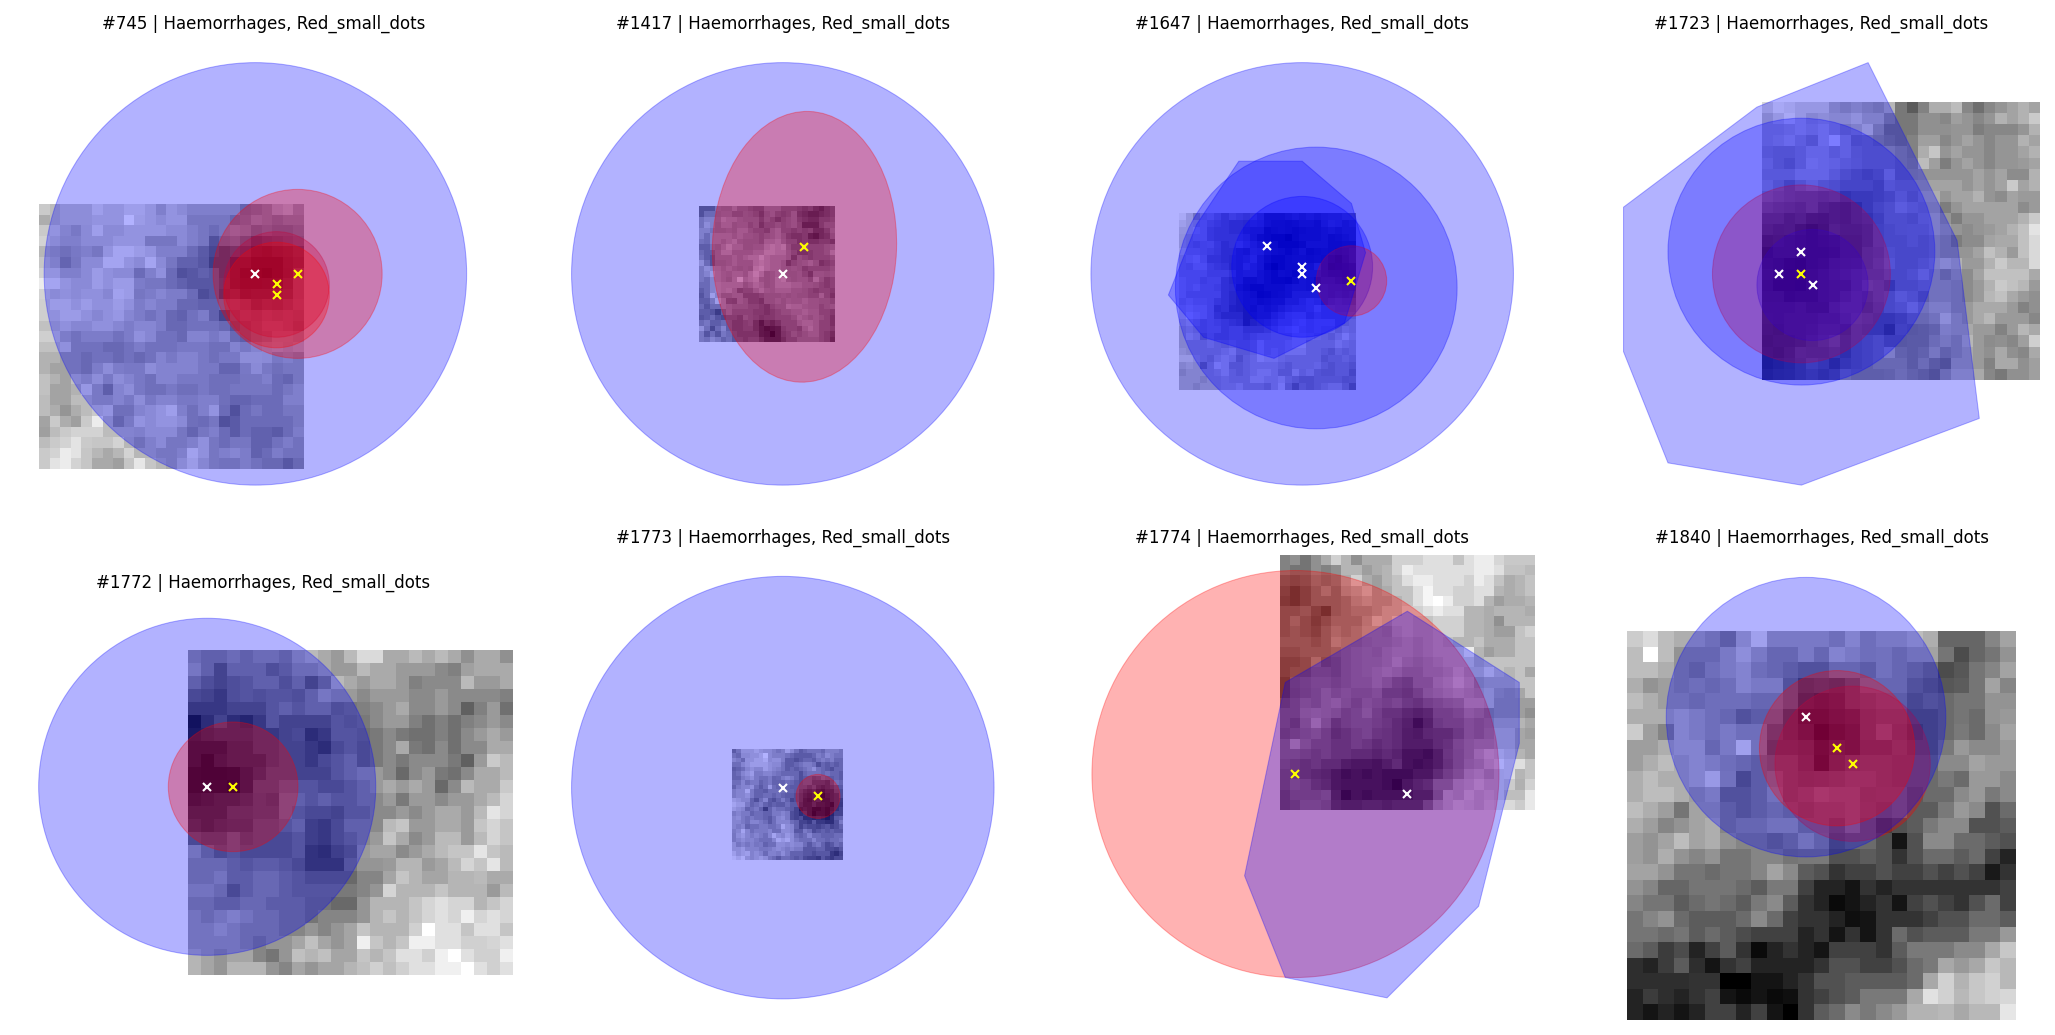

In [32]:
overlapping_patches = labeled_df_green_clahe[
    labeled_df_green_clahe['overlap_flag'] & labeled_df_green_clahe['label'].apply(lambda x: isinstance(x, tuple))
]

visualize_lesion_regions(overlapping_patches, lesions_pd_frame)


---

## Algorithms

### Area Based

In [38]:
def get_dominant_lesion_by_area(patch_coords, local_lesions, in_debug_mode=False):
    # pre: 'patch_coords' contains 'top_left' and 'bottom_right' tuples. 'local_lesions' is a Pandas DataFrame with 'type' and geometric data.
    # post: returns a tuple (dominant_lesion_type, area_map). 'dominant_lesion_type' is 'healthy', a string, or a tuple of strings.
    #       'area_map' maps lesion types to their intersected areas.
    # desc: calculates the dominant lesion type within a specified patch based on the largest intersected area.

    x1, y1 = patch_coords['top_left']
    x2, y2 = patch_coords['bottom_right']
    patch_box = box(x1, y1, x2, y2)

    area_map = {}
    lesion_by_type = {}

    for _, lesion in local_lesions.iterrows():
        shape = get_lesion_geometry(lesion)
        if shape is None or not (patch_box.is_valid and shape.is_valid):
            continue

        intersection = patch_box.intersection(shape)
        if not intersection.is_empty:
            ltype = str(lesion['type']).strip().lower()
            area_map[ltype] = area_map.get(ltype, 0) + intersection.area
            lesion_by_type.setdefault(ltype, []).append(lesion.to_dict())

    if not area_map:
        return "healthy", {}, []

    max_area = max(area_map.values())
    dominant_lesions = [lt for lt, area in area_map.items() if area == max_area]
    final_label = dominant_lesions[0] if len(dominant_lesions) == 1 else tuple(dominant_lesions)

    if isinstance(final_label, str):
        filtered_lesions = [lesion for lesion in lesion_by_type.get(final_label, [])
                            if str(lesion['type']).strip().lower() == final_label]
        filtered_area_map = {final_label: area_map[final_label]}

        # no point in printing maps with just one candidate, hence the len(area_map) > 1
        if in_debug_mode and len(area_map) > 1:
            debug_info = {
                "candidates": {k: round(v, 2) for k, v in area_map.items()},
                "picked": {final_label: round(area_map[final_label], 2)}
            }
            print(json.dumps(debug_info, indent=2))
    else:
        filtered_lesions = []
        filtered_area_map = {}

        # same thing...@see comment above
        if in_debug_mode and len(area_map) > 1:
            debug_info = {
                "candidates": {k: round(v, 2) for k, v in area_map.items()},
                "picked": {label: round(area_map[label], 2) for label in final_label}
            }
            print(json.dumps(debug_info, indent=2))

        for label in final_label:
            filtered_lesions.extend([
                lesion for lesion in lesion_by_type.get(label, [])
                if str(lesion['type']).strip().lower() == label
            ])
            filtered_area_map[label] = area_map[label]

    return final_label, filtered_area_map, filtered_lesions


As mentioned in my earlier report, this function works by figuring out which lesion type takes up the most space inside a given image patch. It loops through each lesion in the patch, checks how much of it actually falls inside the patch boundaries, and adds up the area of those overlaps per lesion type. Once it has a total intersected area for each type, it picks the one with the largest value. If there’s a tie, it returns all of them. This is a pretty intuitive way to determine the dominant lesion, especially when patches might contain multiple overlapping or partially visible lesions.

**[+] Pros:**
- Simple and intuitive, no training, thresholds, or tuning needed
- Geometry-based, uses actual lesion overlap within the patch
- Handles partial overlaps correctly, clipped lesions still contribute
- Deterministic, always returns the same result for the same input
- Simple. Easy to debug and explain

**[-] Cons:**
- Treats all lesion types equally, no awareness of clinical severity
- A large but mild lesion (e.g. red dot) can outweigh a smaller severe one (e.g. IRMA)
- Can return ties when area is equal across types (very rare)

### Area Based with Weights

In [44]:
def get_dominant_lesion_by_area_with_weights(patch_coords, local_lesions, weights_map, in_debug_mode=False):
    # pre: 'patch_coords' contains 'top_left' and 'bottom_right' tuples. 'local_lesions' is a Pandas DataFrame with 'type' and geometric data.
    # post: returns a tuple (dominant_lesion_type, area_map). 'dominant_lesion_type' is 'healthy', a string, or a tuple of strings.
    #       'area_map' maps lesion types to their intersected areas.
    # desc: calculates the dominant lesion type within a specified patch using weighted area (area × weight).

    x1, y1 = patch_coords['top_left']
    x2, y2 = patch_coords['bottom_right']
    patch_box = box(x1, y1, x2, y2)

    area_map = {}
    lesion_by_type = {}

    for _, lesion in local_lesions.iterrows():
        shape = get_lesion_geometry(lesion)
        if shape is None or not (patch_box.is_valid and shape.is_valid):
            continue

        intersection = patch_box.intersection(shape)
        if not intersection.is_empty:
            ltype = str(lesion['type']).strip().lower()
            area_map[ltype] = area_map.get(ltype, 0) + intersection.area
            lesion_by_type.setdefault(ltype, []).append(lesion.to_dict())

    if not area_map:
        return "healthy", {}, []

    # apply weights
    weighted_scores = {}
    for ltype, area in area_map.items():
        weight = weights_map.get(ltype, 0)
        if weight < 0:  # filter -> disc, fundus_area
            continue
        weighted_scores[ltype] = area * weight

    if not weighted_scores:
        return "healthy", {}, []

    max_score = max(weighted_scores.values())
    dominant_lesions = [lt for lt, score in weighted_scores.items() if score == max_score]
    final_label = dominant_lesions[0] if len(dominant_lesions) == 1 else tuple(dominant_lesions)

    if isinstance(final_label, str):
        filtered_lesions = [lesion for lesion in lesion_by_type.get(final_label, [])
                            if str(lesion['type']).strip().lower() == final_label]
        filtered_area_map = {final_label: area_map[final_label]}

        if in_debug_mode and len(weighted_scores) > 1:
            debug_info = {
                "candidates": {k: round(v, 2) for k, v in weighted_scores.items()},
                "picked": {final_label: round(weighted_scores[final_label], 2)}
            }
            print(json.dumps(debug_info, indent=2))
    else:
        filtered_lesions = []
        filtered_area_map = {}

        if in_debug_mode and len(weighted_scores) > 1:
            debug_info = {
                "candidates": {k: round(v, 2) for k, v in weighted_scores.items()},
                "picked": {label: round(weighted_scores[label], 2) for label in final_label}
            }
            print(json.dumps(debug_info, indent=2))

        for label in final_label:
            filtered_lesions.extend([
                lesion for lesion in lesion_by_type.get(label, [])
                if str(lesion['type']).strip().lower() == label
            ])
            filtered_area_map[label] = area_map[label]

    return final_label, filtered_area_map, filtered_lesions


This version builds on the plain area-based approach by introducing lesion-specific weights. Each lesion type is given an importance score (weight), and its area within the patch is multiplied by that weight to get a final score. The lesion type with the highest weighted score is picked as the dominant one. This helps avoid situations where a large but mild lesion overshadows a smaller but more serious one. It's still fast and easy to understand, but now a bit more aligned with clinical priorities.


**[+] Pros:**
- Uses both area and clinical weight, so more meaningful lesions carry more influence
- Can downrank large but unimportant structures like the optic disc or fundus area
- Helps avoid false dominance by low-risk but high-area lesions
- Still keeps the simplicity and explainability of the area-based approach
- Easy to experiment with different weighting strategies

This is mostly about subjectiveness. We can discuss this on Monday...

**[-] Cons:**
- Weights have to be hand-tuned or justified...which adds some subjectivity
- Sensitive to badly chosen weights...especially when lesion areas are small
- Doesn't consider spatial distribution or clustering of lesions
- Ties are still possible if weighted scores match...unlikely tho
- No dynamic context awareness, just multiplies two numbers and picks the biggest

### Area Based with Weights and DBSCAN

In [83]:
def get_dominant_lesion_by_dbscan_weighted_area(patch_coords, local_lesions, weights_map, in_debug_mode=False, eps=5, min_samples=1):
    # pre: 'patch_coords' defines the patch bounding box; 'local_lesions' is a DataFrame with lesion info and geometry.
    # post: returns (dominant_lesion_type, area_map, filtered_lesions), where type is 'healthy', str, or tuple.
    # desc: identifies the dominant lesion type in a patch using DBSCAN clustering and weighted area (area × clinical weight).

    x1, y1 = patch_coords['top_left']
    x2, y2 = patch_coords['bottom_right']
    patch_box = box(x1, y1, x2, y2)

    lesion_records = []

    for _, lesion in local_lesions.iterrows():
        shape = get_lesion_geometry(lesion)
        if shape is None or not (patch_box.is_valid and shape.is_valid):
            continue

        intersection = patch_box.intersection(shape)
        if intersection.is_empty:
            continue

        ltype = str(lesion['type']).strip().lower()
        weight = weights_map.get(ltype, 0)
        if weight < 0:
            continue  # skip disc/fundus_area

        score = intersection.area * weight
        if score == 0:
            continue

        centroid = shape.centroid
        lesion_records.append({
            'type': ltype,
            'score': score,
            'area': intersection.area,
            'x': centroid.x,
            'y': centroid.y,
            'lesion': lesion.to_dict()
        })

    if not lesion_records:
        return "healthy", {}, []

    coords = np.array([[r['x'], r['y']] for r in lesion_records])
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    labels = db.labels_

    cluster_scores = {}
    cluster_lesions = {}

    for i, cluster_id in enumerate(labels):
        ltype = lesion_records[i]['type']
        score = lesion_records[i]['score']
        cluster_scores.setdefault(ltype, 0)
        cluster_scores[ltype] += score
        cluster_lesions.setdefault(ltype, []).append(lesion_records[i]['lesion'])

    if not cluster_scores:
        return "healthy", {}, []

    max_score = max(cluster_scores.values())
    dominant_lesions = [lt for lt, score in cluster_scores.items() if score == max_score]
    final_label = dominant_lesions[0] if len(dominant_lesions) == 1 else tuple(dominant_lesions)

    filtered_area_map = {lt: sum(r['area'] for i, r in enumerate(lesion_records) if r['type'] == lt)
                         for lt in dominant_lesions}
    filtered_lesions = []
    for lt in dominant_lesions:
        filtered_lesions.extend(cluster_lesions[lt])

    if in_debug_mode and len(cluster_scores) > 1:
        debug_info = {
            "candidates": {k: round(v, 2) for k, v in cluster_scores.items()},
            "picked": final_label if isinstance(final_label, str)
                     else {k: round(cluster_scores[k], 2) for k in final_label}
        }
        print(json.dumps(debug_info, indent=2))

    return final_label, filtered_area_map, filtered_lesions


This version adds clustering into the mix. Instead of looking at lesion area and weight in isolation, it runs `DBSCAN` (clustering algorithm) to group lesions that are spatially close together. Then it scores each lesion by multiplying its patch-overlap area by a clinical weight, and sums those scores by type within the clusters. 

The dominant lesion type is the one with the highest total score across all clusters. This helps in noisy patches where several small lesions might not individually dominate but clearly form a meaningful group. It's a more context-aware strategy, especially useful when lesion density matters.

**[+] Pros:**
- Takes spatial grouping into account, not just raw overlap
- More robust to scattered or overlapping small lesions
- Works well when multiple small lesions form meaningful clusters
- Still honors area and clinical weight, just in a more structured way
- Can reduce noise from isolated artifacts

**[+] Cons:**
- Adds complexity and a few tunable parameters like `eps` and `min_samples`
- Slightly slower due to clustering step
- Choice of clustering scale can affect results significantly
- Still relies on hand-defined weights
- Not guaranteed to improve results in patches with very few lesions

---

## Results

### Area Based

In [52]:
strategy_with_debug = partial(
    get_dominant_lesion_by_area,
    in_debug_mode=True
)

relabeled_area_df = relabel_patches_with(
    labeled_df_green_clahe,
    lesions_pd_frame,
    strategy_fn=strategy_with_debug
)

filtered_area_df = extract_largest_lesions_from_relabel(relabeled_area_df)


{
  "candidates": {
    "red_small_dots": 210.44,
    "haemorrhages": 516.13
  },
  "picked": {
    "haemorrhages": 516.13
  }
}
{
  "candidates": {
    "haemorrhages": 576.0,
    "red_small_dots": 504.28
  },
  "picked": {
    "haemorrhages": 576.0
  }
}
{
  "candidates": {
    "haemorrhages": 1800.21,
    "red_small_dots": 39.21
  },
  "picked": {
    "haemorrhages": 1800.21
  }
}
{
  "candidates": {
    "haemorrhages": 746.6,
    "red_small_dots": 147.18
  },
  "picked": {
    "haemorrhages": 746.6
  }
}
{
  "candidates": {
    "haemorrhages": 271.07,
    "red_small_dots": 67.27
  },
  "picked": {
    "haemorrhages": 271.07
  }
}
{
  "candidates": {
    "haemorrhages": 576.0,
    "red_small_dots": 78.41
  },
  "picked": {
    "haemorrhages": 576.0
  }
}
{
  "candidates": {
    "red_small_dots": 396.36,
    "haemorrhages": 352.0
  },
  "picked": {
    "red_small_dots": 396.36
  }
}
{
  "candidates": {
    "red_small_dots": 156.83,
    "haemorrhages": 212.08
  },
  "picked": {
    "ha

This is here just to give you some insights on how the process works. It picks the candidate with the largest area, no matter the shape.

In [53]:
filtered_area_df.head(n=2)


,source_img,patch_no,patch,center,coordinates,label,overlap_flag,lesion_id,relabel_label,relabel_meta,relabel
0,diaretdb1_image002.png,1,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(12, 12)","{'top_left': (0, 0), 'top_right': (24, 0), 'bo...",healthy,False,0,healthy,{},[]
1,diaretdb1_image002.png,2,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3,...","(37, 12)","{'top_left': (25, 0), 'top_right': (49, 0), 'b...",healthy,False,1,healthy,{},[]


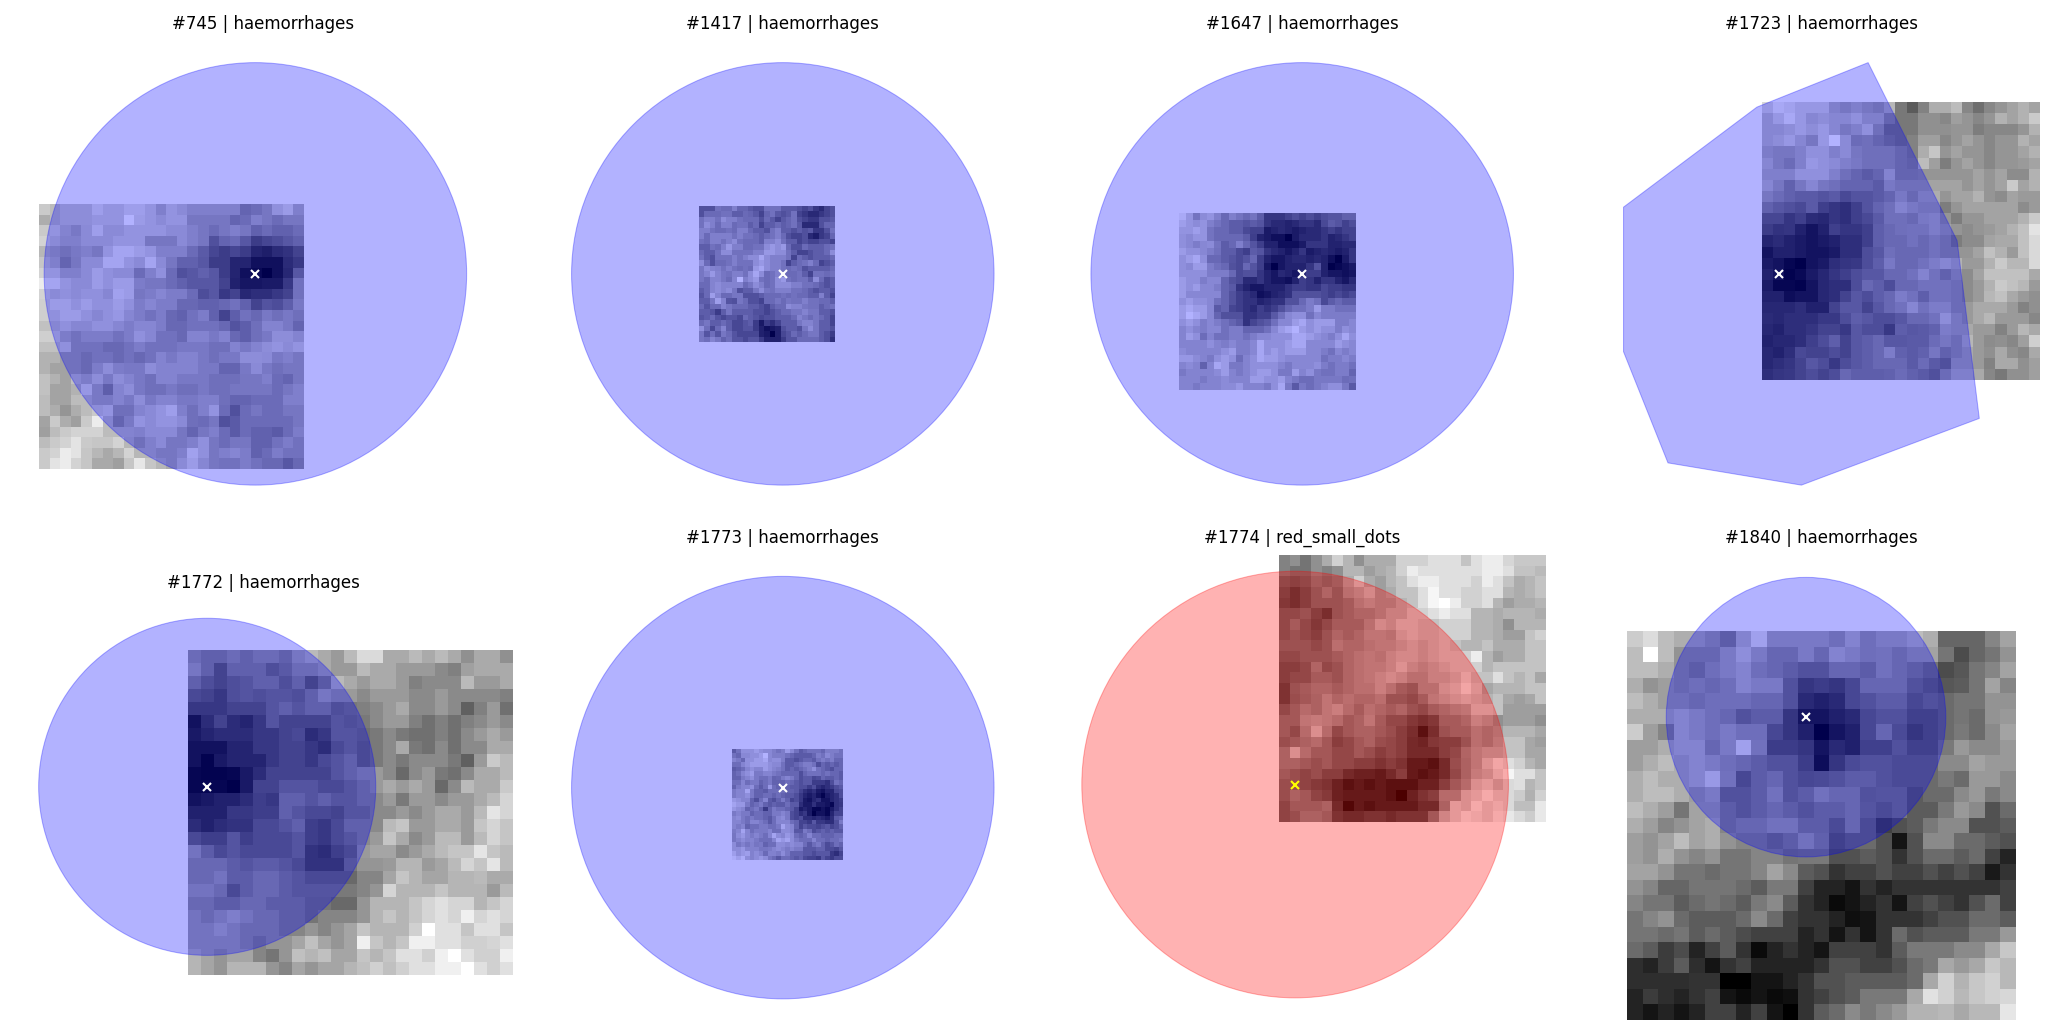

In [93]:
selected_patches = filtered_area_df[filtered_area_df['patch_no'].isin(TARGET_PATCHES)].copy()

visualize_lesion_regions(selected_patches, from_relabel=True)


### Area Based with Weights

#### `MAP #1` | Linear Severity Scaling

In [94]:
relabeled_area_weights_df = relabel_patches_with(
    labeled_df_green_clahe,
    lesions_pd_frame,
    strategy_fn=lambda coords, lesions: get_dominant_lesion_by_area_with_weights(
        coords, lesions, weights_map=WEIGHTS_MAP_1, in_debug_mode=True
    )
)

filtered_area_weights_df_1 = extract_largest_lesions_from_relabel(relabeled_area_weights_df)



{
  "candidates": {
    "red_small_dots": 21.04,
    "haemorrhages": 258.07
  },
  "picked": {
    "haemorrhages": 258.07
  }
}
{
  "candidates": {
    "haemorrhages": 288.0,
    "red_small_dots": 50.43
  },
  "picked": {
    "haemorrhages": 288.0
  }
}
{
  "candidates": {
    "haemorrhages": 900.11,
    "red_small_dots": 3.92
  },
  "picked": {
    "haemorrhages": 900.11
  }
}
{
  "candidates": {
    "haemorrhages": 373.3,
    "red_small_dots": 14.72
  },
  "picked": {
    "haemorrhages": 373.3
  }
}
{
  "candidates": {
    "haemorrhages": 135.53,
    "red_small_dots": 6.73
  },
  "picked": {
    "haemorrhages": 135.53
  }
}
{
  "candidates": {
    "haemorrhages": 288.0,
    "red_small_dots": 7.84
  },
  "picked": {
    "haemorrhages": 288.0
  }
}
{
  "candidates": {
    "red_small_dots": 39.64,
    "haemorrhages": 176.0
  },
  "picked": {
    "haemorrhages": 176.0
  }
}
{
  "candidates": {
    "red_small_dots": 15.68,
    "haemorrhages": 106.04
  },
  "picked": {
    "haemorrhages": 

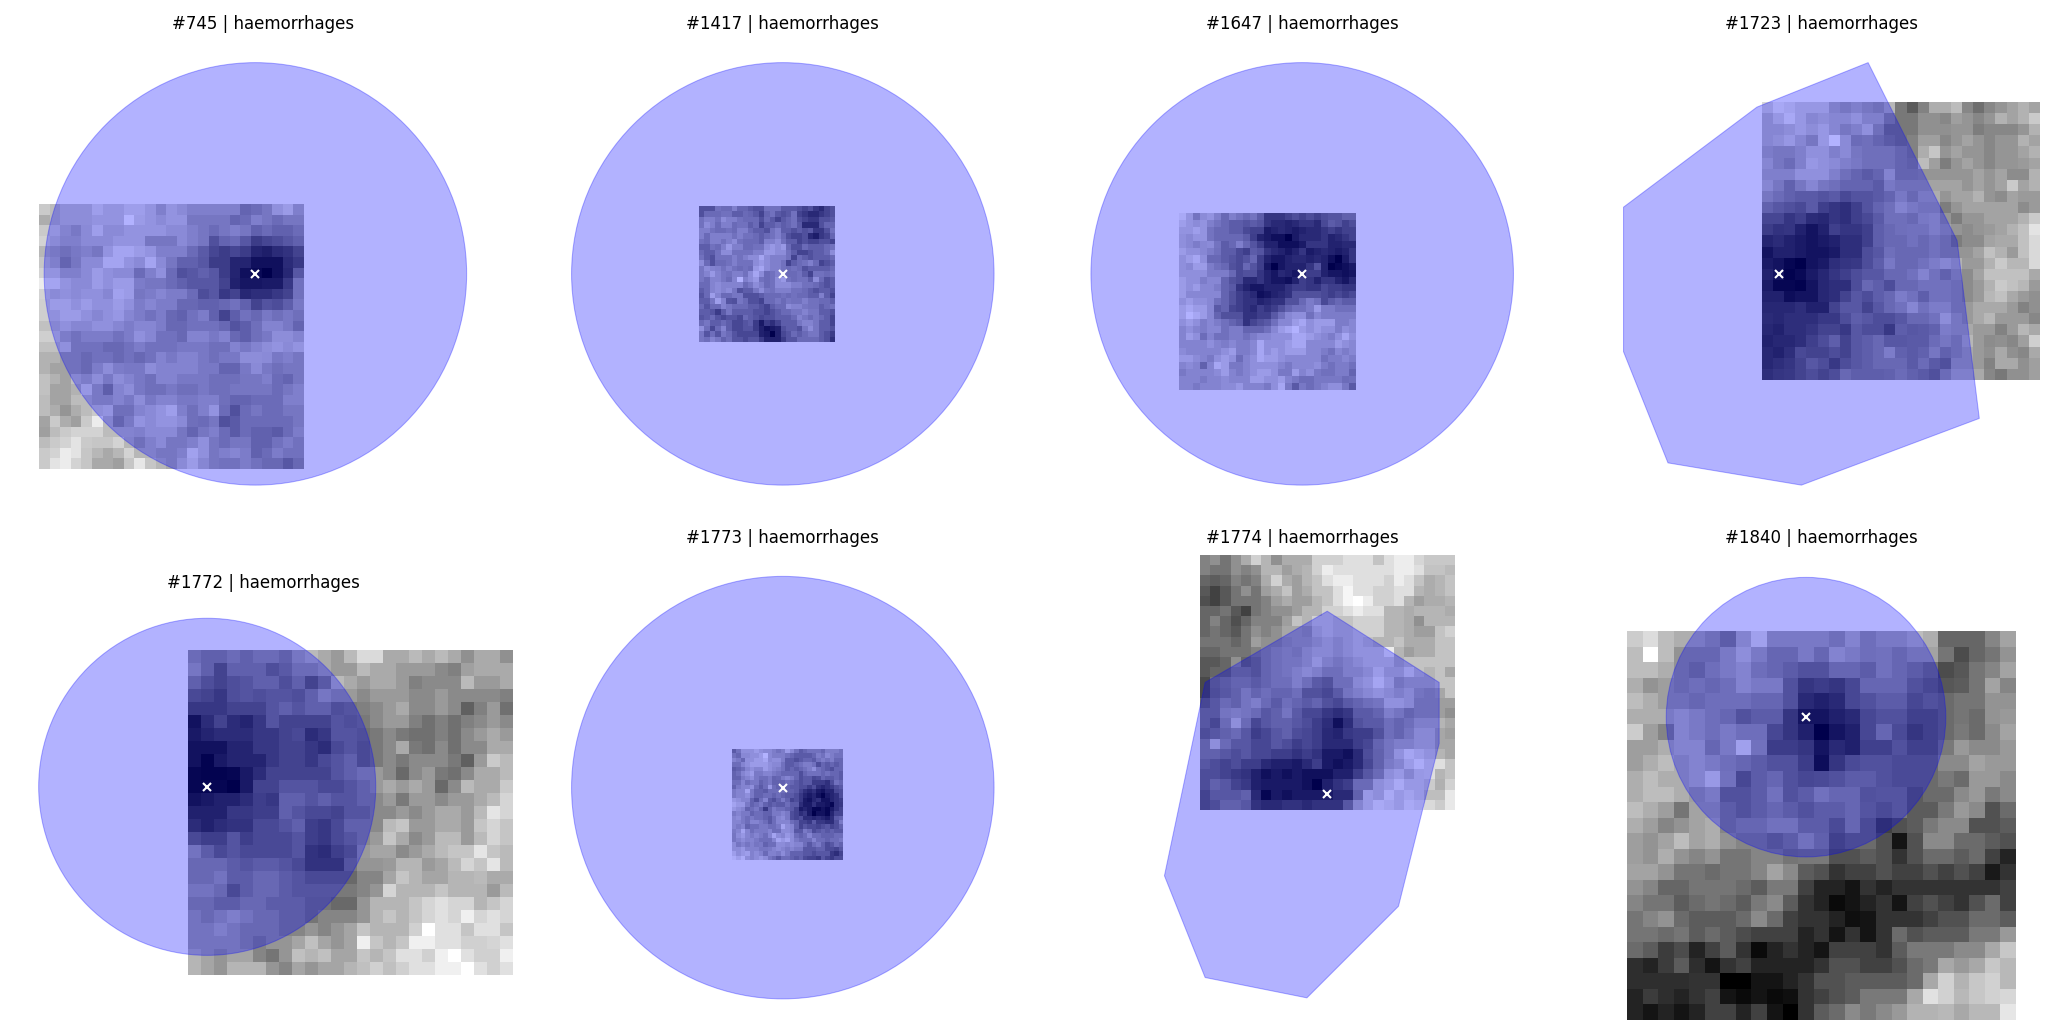

In [92]:
selected_patches = filtered_area_weights_df_1[filtered_area_weights_df_1['patch_no'].isin(TARGET_PATCHES)].copy()

visualize_lesion_regions(selected_patches, from_relabel=True)


#### `MAP #2` | Risk Adjusted Weighting

In [95]:
relabeled_area_weights_df = relabel_patches_with(
    labeled_df_green_clahe,
    lesions_pd_frame,
    strategy_fn=lambda coords, lesions: get_dominant_lesion_by_area_with_weights(
        coords, lesions, weights_map=WEIGHTS_MAP_2, in_debug_mode=True
    )
)

filtered_area_weights_df_2 = extract_largest_lesions_from_relabel(relabeled_area_weights_df)


{
  "candidates": {
    "red_small_dots": 10.52,
    "haemorrhages": 206.45
  },
  "picked": {
    "haemorrhages": 206.45
  }
}
{
  "candidates": {
    "haemorrhages": 230.4,
    "red_small_dots": 25.21
  },
  "picked": {
    "haemorrhages": 230.4
  }
}
{
  "candidates": {
    "haemorrhages": 720.08,
    "red_small_dots": 1.96
  },
  "picked": {
    "haemorrhages": 720.08
  }
}
{
  "candidates": {
    "haemorrhages": 298.64,
    "red_small_dots": 7.36
  },
  "picked": {
    "haemorrhages": 298.64
  }
}
{
  "candidates": {
    "haemorrhages": 108.43,
    "red_small_dots": 3.36
  },
  "picked": {
    "haemorrhages": 108.43
  }
}
{
  "candidates": {
    "haemorrhages": 230.4,
    "red_small_dots": 3.92
  },
  "picked": {
    "haemorrhages": 230.4
  }
}
{
  "candidates": {
    "red_small_dots": 19.82,
    "haemorrhages": 140.8
  },
  "picked": {
    "haemorrhages": 140.8
  }
}
{
  "candidates": {
    "red_small_dots": 7.84,
    "haemorrhages": 84.83
  },
  "picked": {
    "haemorrhages": 8

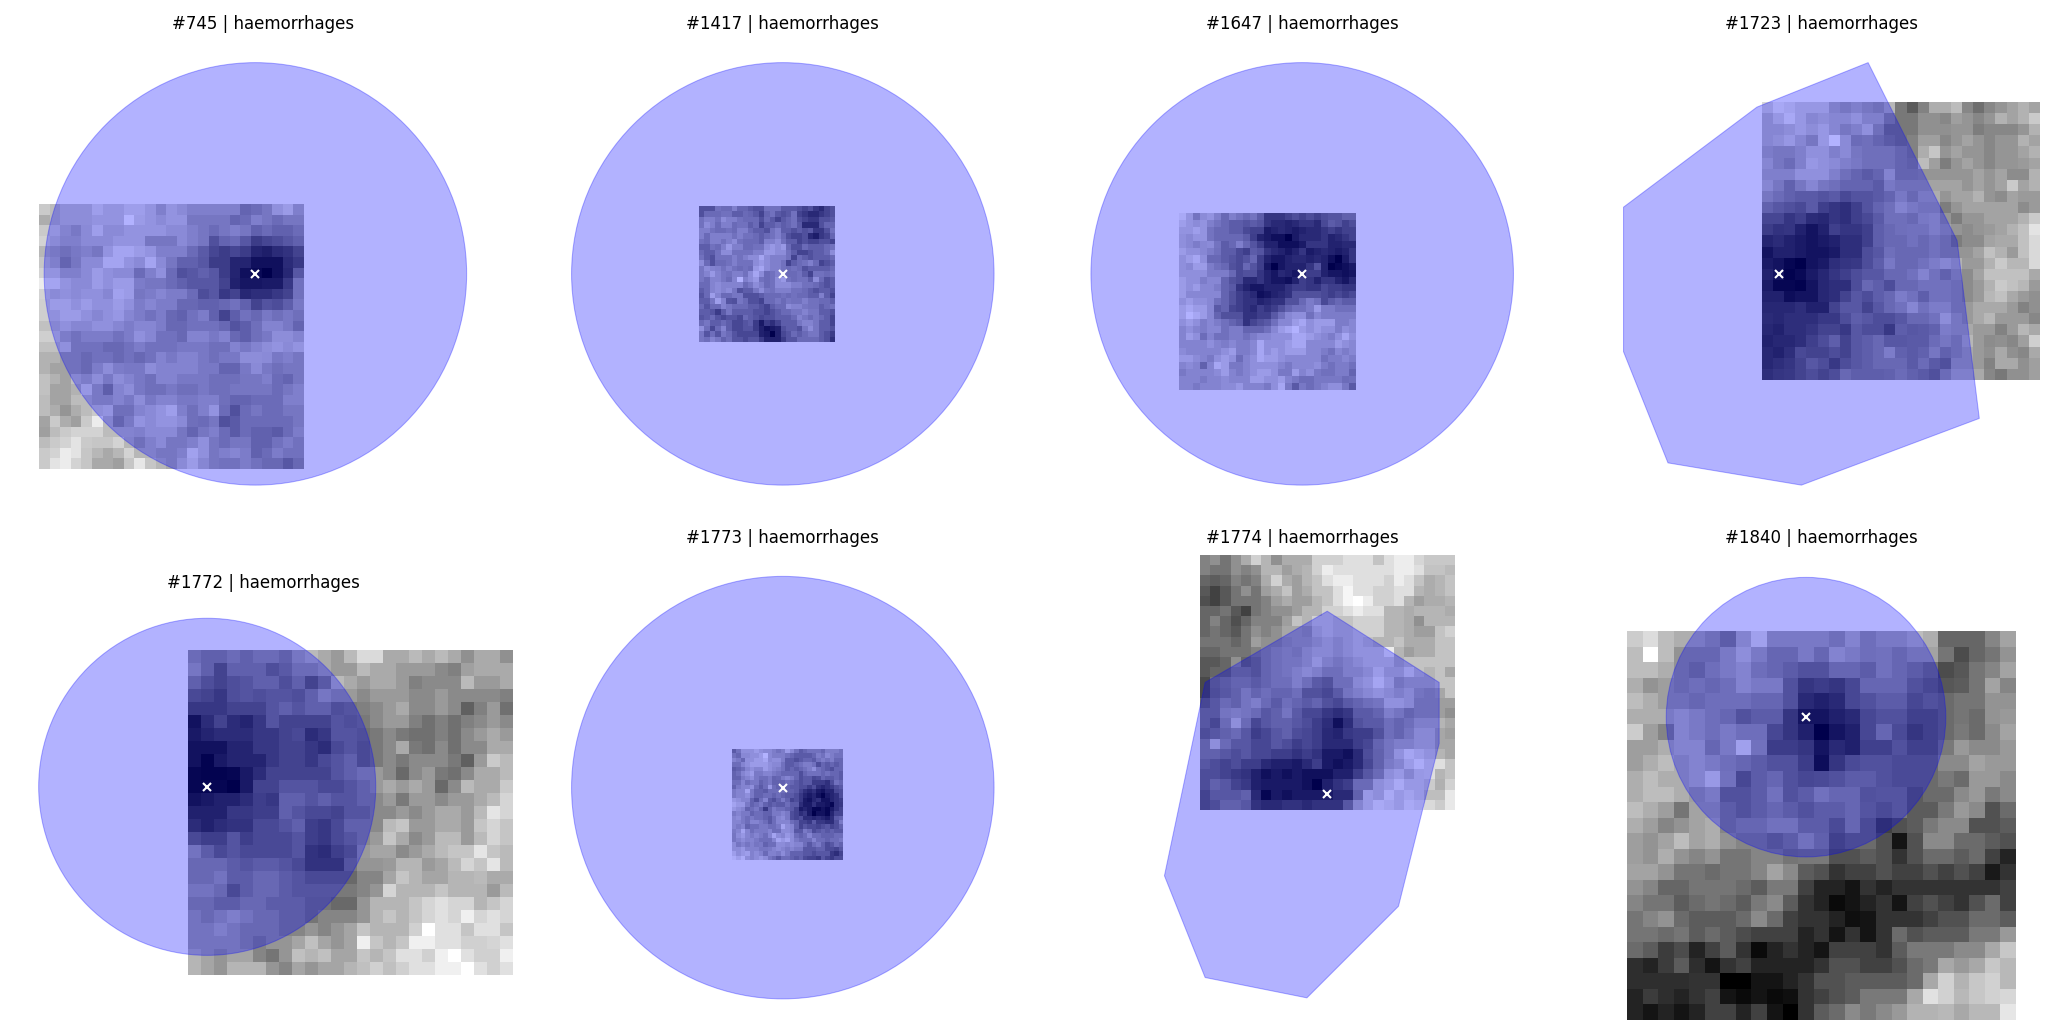

In [91]:
selected_patches = filtered_area_weights_df_2[filtered_area_weights_df_2['patch_no'].isin(TARGET_PATCHES)].copy()

visualize_lesion_regions(selected_patches, from_relabel=True)


#### `MAP #3` | Clinical Tradeoff

In [96]:
relabeled_area_weights_df = relabel_patches_with(
    labeled_df_green_clahe,
    lesions_pd_frame,
    strategy_fn=lambda coords, lesions: get_dominant_lesion_by_area_with_weights(
        coords, lesions, weights_map=WEIGHTS_MAP_3, in_debug_mode=True
    )
)

filtered_area_weights_df_3 = extract_largest_lesions_from_relabel(relabeled_area_weights_df)


{
  "candidates": {
    "red_small_dots": 105.22,
    "haemorrhages": 361.29
  },
  "picked": {
    "haemorrhages": 361.29
  }
}
{
  "candidates": {
    "haemorrhages": 403.2,
    "red_small_dots": 252.14
  },
  "picked": {
    "haemorrhages": 403.2
  }
}
{
  "candidates": {
    "haemorrhages": 1260.15,
    "red_small_dots": 19.6
  },
  "picked": {
    "haemorrhages": 1260.15
  }
}
{
  "candidates": {
    "haemorrhages": 522.62,
    "red_small_dots": 73.59
  },
  "picked": {
    "haemorrhages": 522.62
  }
}
{
  "candidates": {
    "haemorrhages": 189.75,
    "red_small_dots": 33.63
  },
  "picked": {
    "haemorrhages": 189.75
  }
}
{
  "candidates": {
    "haemorrhages": 403.2,
    "red_small_dots": 39.21
  },
  "picked": {
    "haemorrhages": 403.2
  }
}
{
  "candidates": {
    "red_small_dots": 198.18,
    "haemorrhages": 246.4
  },
  "picked": {
    "haemorrhages": 246.4
  }
}
{
  "candidates": {
    "red_small_dots": 78.41,
    "haemorrhages": 148.46
  },
  "picked": {
    "haemor

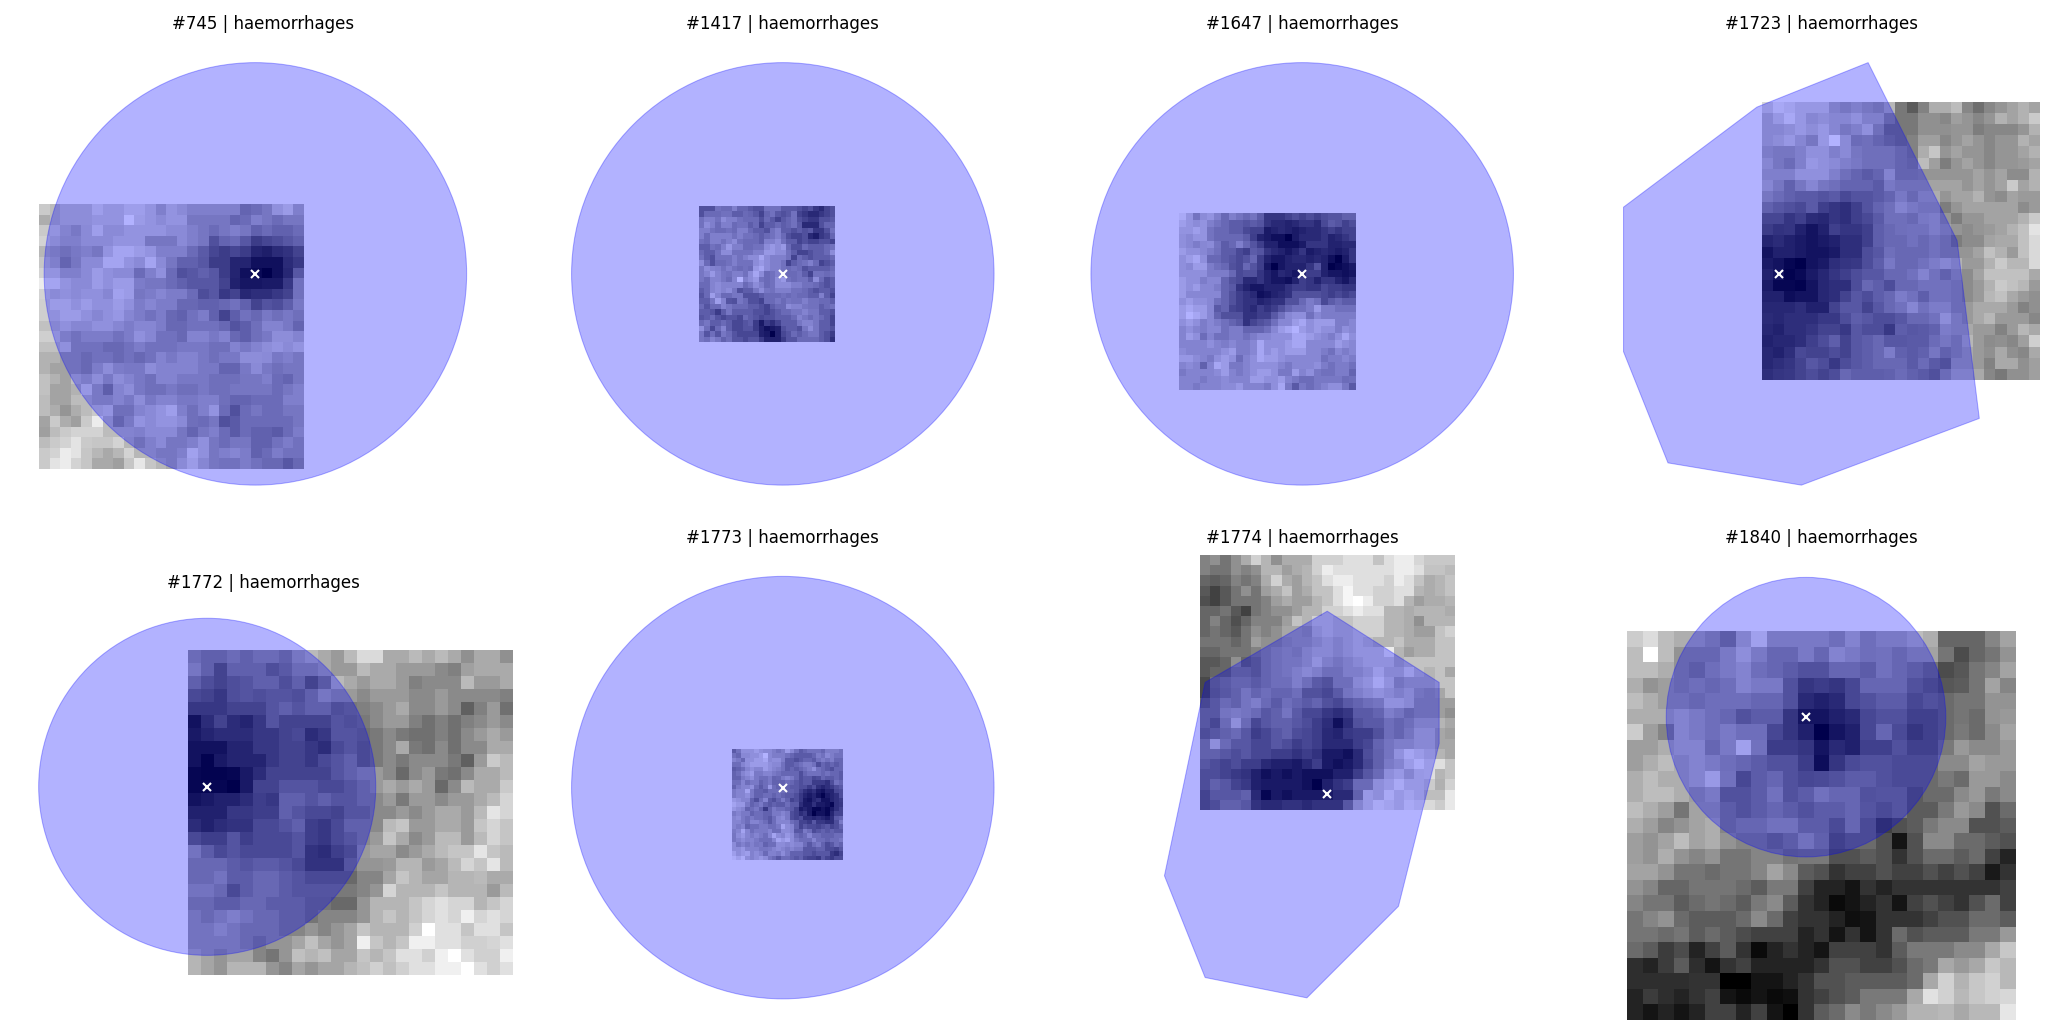

In [90]:
selected_patches = filtered_area_weights_df_3[filtered_area_weights_df_3['patch_no'].isin(TARGET_PATCHES)].copy()

visualize_lesion_regions(selected_patches, from_relabel=True)


### Area Based with Weights and DBSCAN

In [97]:
relabeled_area_weights_dbscan_df = relabel_patches_with(
    labeled_df_green_clahe,
    lesions_pd_frame,
    strategy_fn=lambda coords, lesions: get_dominant_lesion_by_dbscan_weighted_area(
        coords, lesions, weights_map=WEIGHTS_MAP_1, in_debug_mode=True, eps=20, min_samples=1
    )
)

filtered_weights_area_dbscan_df_1 = extract_largest_lesions_from_relabel(relabeled_area_weights_dbscan_df)


{
  "candidates": {
    "red_small_dots": 21.04,
    "haemorrhages": 258.07
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 288.0,
    "red_small_dots": 50.43
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 900.11,
    "red_small_dots": 3.92
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 373.3,
    "red_small_dots": 14.72
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 135.53,
    "red_small_dots": 6.73
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 288.0,
    "red_small_dots": 7.84
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "red_small_dots": 39.64,
    "haemorrhages": 176.0
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "red_small_dots": 15.68,
    "haemorrhages": 106.04
  },
  "picked": "haemorrhages"
}


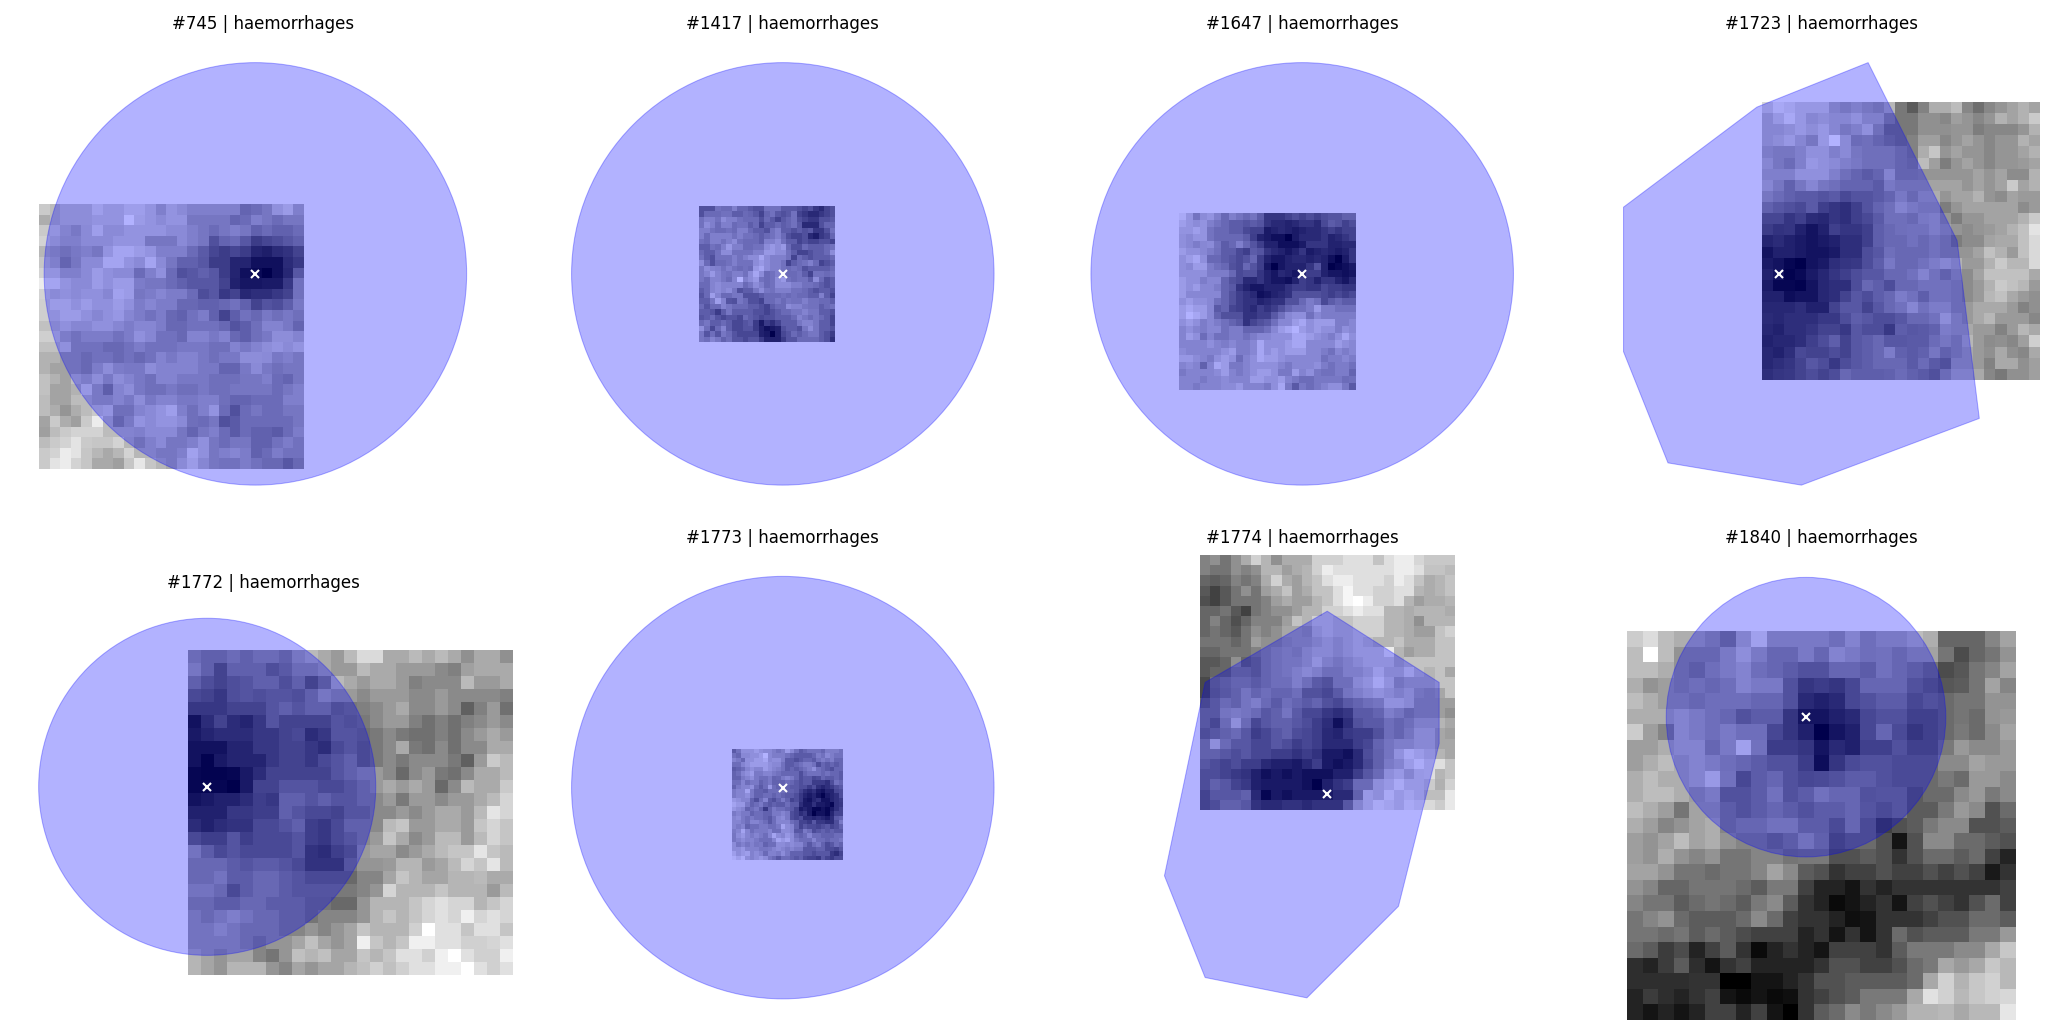

In [89]:
selected_patches = filtered_weights_area_dbscan_df_1[filtered_weights_area_dbscan_df_1['patch_no'].isin(TARGET_PATCHES)].copy()

visualize_lesion_regions(selected_patches, from_relabel=True)


In [98]:
relabeled_area_weights_dbscan_df = relabel_patches_with(
    labeled_df_green_clahe,
    lesions_pd_frame,
    strategy_fn=lambda coords, lesions: get_dominant_lesion_by_dbscan_weighted_area(
        coords, lesions, weights_map=WEIGHTS_MAP_2, in_debug_mode=True, eps=20, min_samples=1
    )
)

filtered_weights_area_dbscan_df_2 = extract_largest_lesions_from_relabel(relabeled_area_weights_dbscan_df)


{
  "candidates": {
    "red_small_dots": 10.52,
    "haemorrhages": 206.45
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 230.4,
    "red_small_dots": 25.21
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 720.08,
    "red_small_dots": 1.96
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 298.64,
    "red_small_dots": 7.36
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 108.43,
    "red_small_dots": 3.36
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 230.4,
    "red_small_dots": 3.92
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "red_small_dots": 19.82,
    "haemorrhages": 140.8
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "red_small_dots": 7.84,
    "haemorrhages": 84.83
  },
  "picked": "haemorrhages"
}


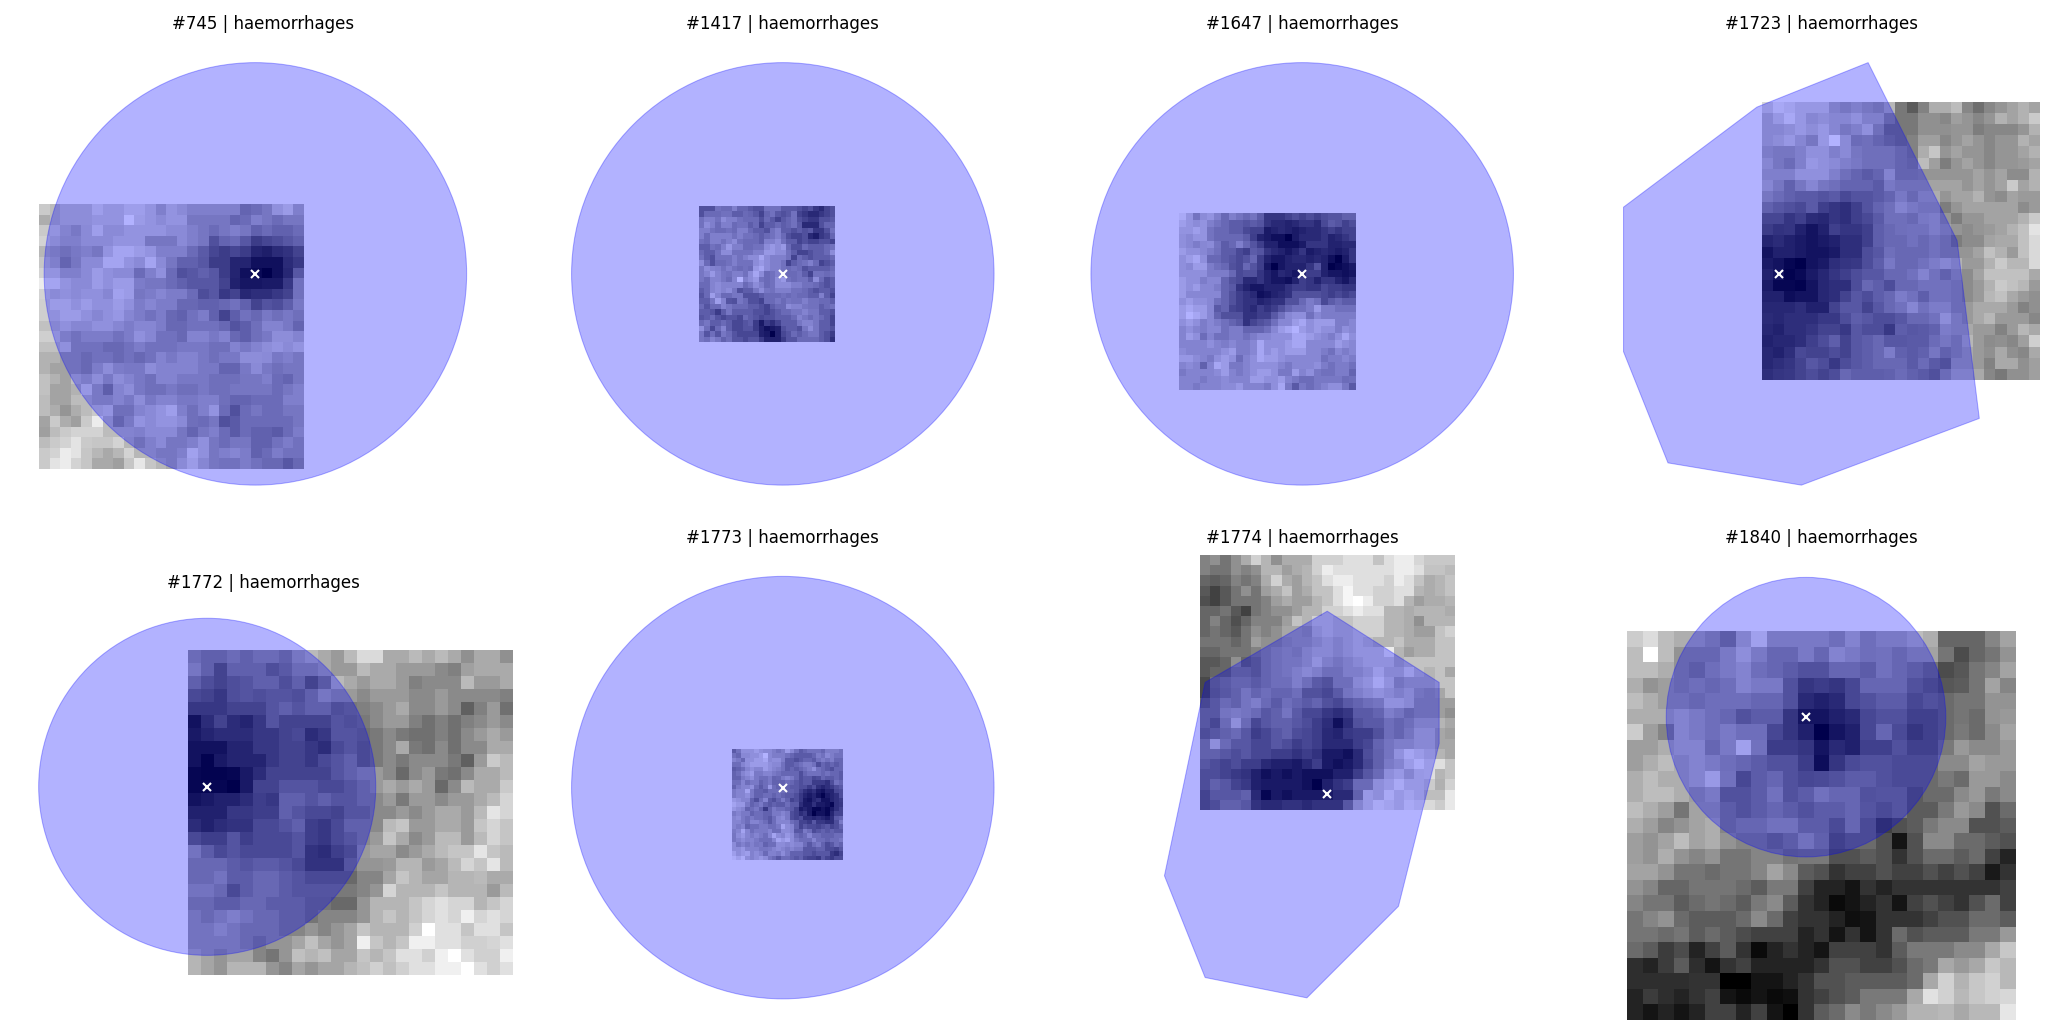

In [88]:
selected_patches = filtered_weights_area_dbscan_df_2[filtered_weights_area_dbscan_df_2['patch_no'].isin(TARGET_PATCHES)].copy()

visualize_lesion_regions(selected_patches, from_relabel=True)


In [99]:
relabeled_area_weights_dbscan_df = relabel_patches_with(
    labeled_df_green_clahe,
    lesions_pd_frame,
    strategy_fn=lambda coords, lesions: get_dominant_lesion_by_dbscan_weighted_area(
        coords, lesions, weights_map=WEIGHTS_MAP_3, in_debug_mode=True, eps=20, min_samples=1
    )
)

filtered_weights_area_dbscan_df_3 = extract_largest_lesions_from_relabel(relabeled_area_weights_dbscan_df)


{
  "candidates": {
    "red_small_dots": 105.22,
    "haemorrhages": 361.29
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 403.2,
    "red_small_dots": 252.14
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 1260.15,
    "red_small_dots": 19.6
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 522.62,
    "red_small_dots": 73.59
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 189.75,
    "red_small_dots": 33.63
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "haemorrhages": 403.2,
    "red_small_dots": 39.21
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "red_small_dots": 198.18,
    "haemorrhages": 246.4
  },
  "picked": "haemorrhages"
}
{
  "candidates": {
    "red_small_dots": 78.41,
    "haemorrhages": 148.46
  },
  "picked": "haemorrhages"
}


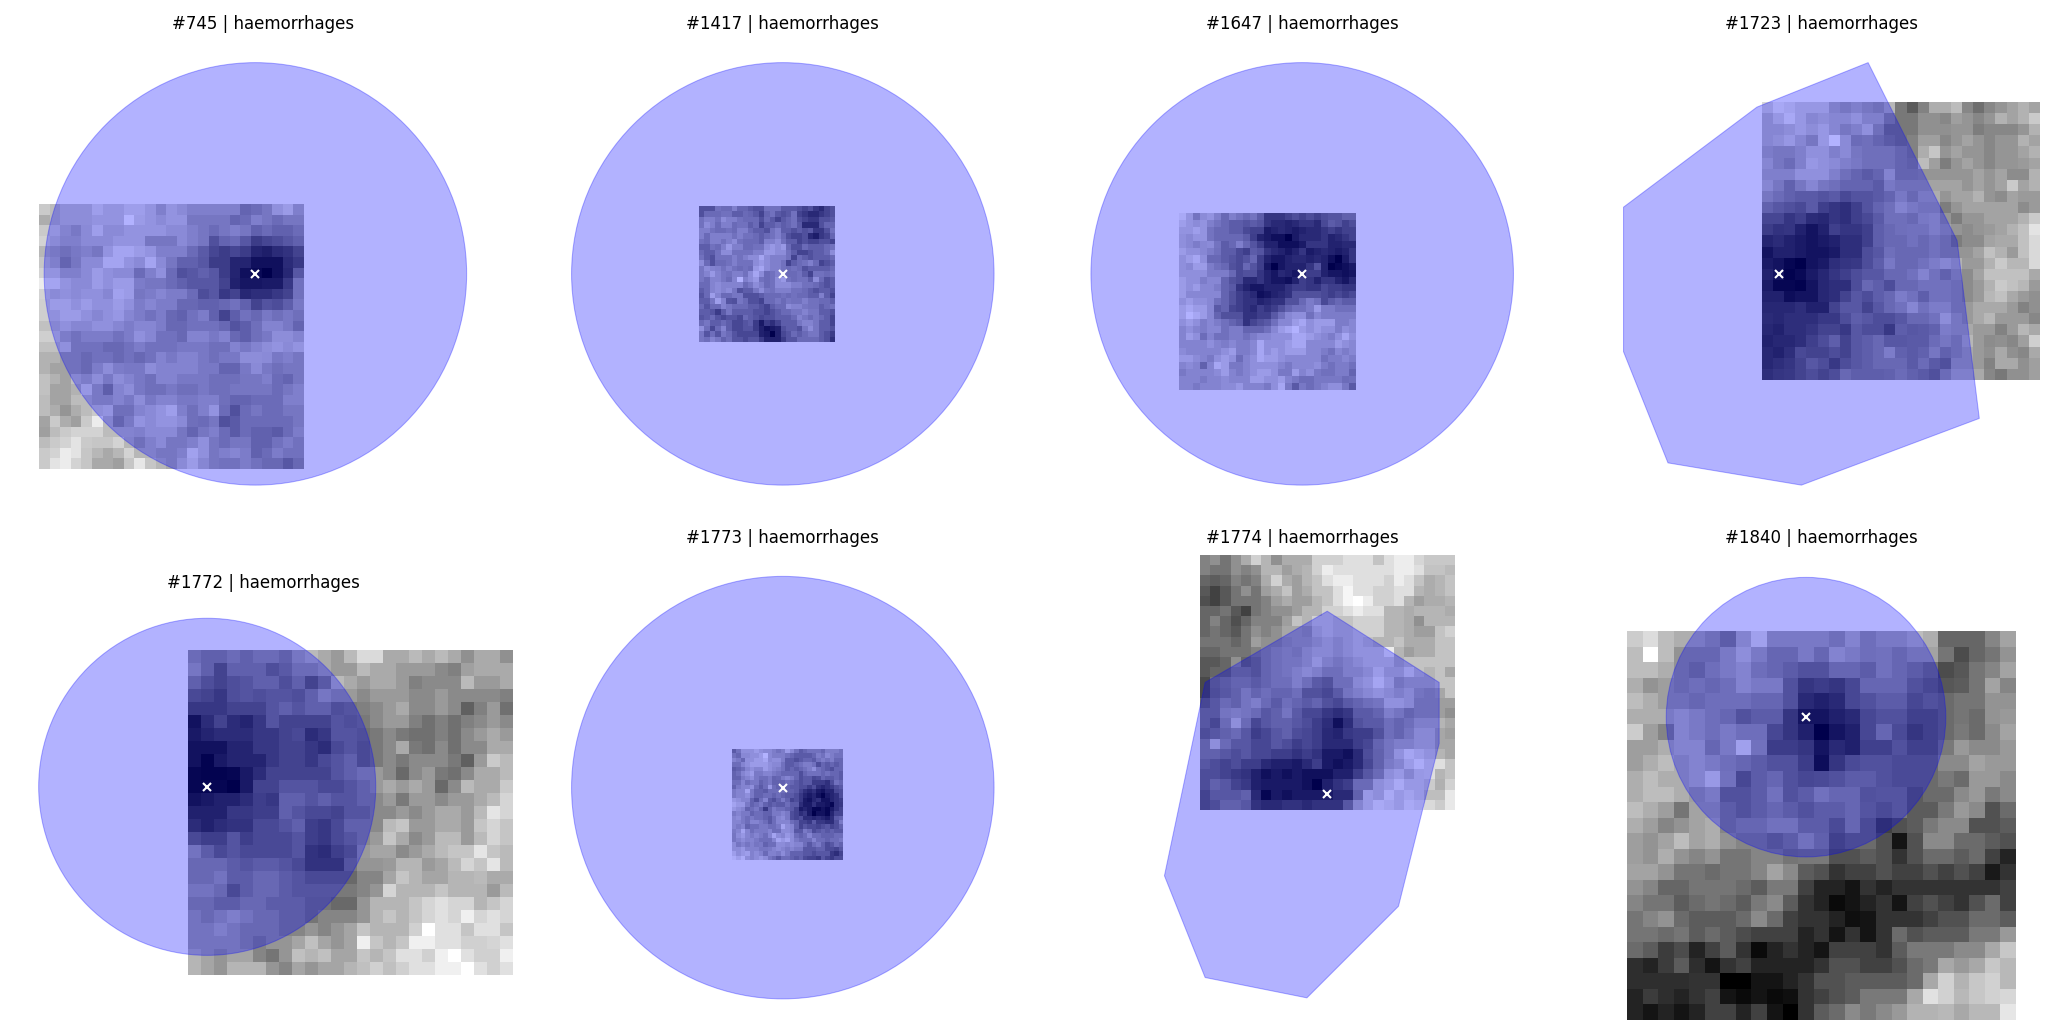

In [87]:
selected_patches = filtered_weights_area_dbscan_df_3[filtered_weights_area_dbscan_df_3['patch_no'].isin(TARGET_PATCHES)].copy()

visualize_lesion_regions(selected_patches, from_relabel=True)
